# Model comparisons

In this notebook, we'll take BartPy through its paces using increasingly complex sin wave models.  We'll compare how it performs to two similar models: OLS and catboost.

For the purposes of this exercise, I'm testing out of the box performance.  This makes sense, as part of the value prop of BartPy is it's ability to work well without parameter tuning, but it's possible that the scores of all of the models could be improved with parameter tuning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel

%matplotlib inline

## Set up models

In [2]:
def fit_catboost(X_train, y_train, X_test, y_test):
    eval_cutoff = len(X_train) // 3
    eval_X, eval_y, train_X, train_y = X_train[:eval_cutoff, :], y_train[:eval_cutoff], X_train[eval_cutoff:, :], y_train[eval_cutoff:]
    catboost_model = catboost.CatBoostRegressor()
    catboost_model.fit(Pool(train_X, train_y), eval_set = Pool(eval_X, eval_y), use_best_model=True)
    pred = catboost_model.predict(X_test)
    score = r2_score(y_test, pred)
    return catboost_model, pred, score

def fit_bartpy(X_train, y_train, X_test, y_test):
    model = SklearnModel(n_samples=1000, n_burn=500, n_trees=500, store_in_sample_predictions=False)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return model, pred, score

def fit_linear_model(X_train, y_train, X_test, y_test):
    rebased_x = np.sin(X_train[:, 0]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(rebased_x, y_train)
    pred = linear_model.predict(np.sin(X_test[:, 0]).reshape(-1, 1))
    score = linear_model.score(np.sin(X_test[:, 0]).reshape(-1, 1), y_test)
    return linear_model, pred, score

kf = KFold(2)

def compare_models(X, y, models_funcs = [fit_bartpy, fit_catboost, fit_linear_model]):
    scores, predictions, trained_models = [], [], []

    for train_index, test_index in kf.split(X):
        trained_models.append([])    
        scores.append([])
        predictions.append([])

        for f in models_funcs:
            model, pred, score = f(X[train_index, :], y[train_index], X[test_index, :], y[test_index])
            trained_models[-1].append(deepcopy(model))
            predictions[-1].append(pred)
            scores[-1].append(score)
    return scores, predictions, trained_models

## One dimensional, single wave

Text(0.5,1,'X v y')

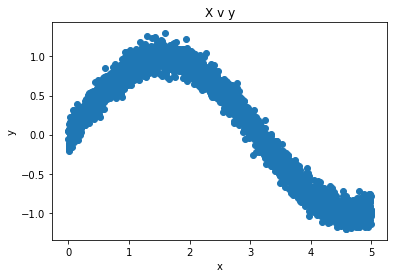

In [3]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [4]:
scores, predictions, models = compare_models(X, y, [fit_bartpy])

Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.42it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.77it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.06it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


In [6]:
scores

[[0.9801113454465189], [0.9796981103508424]]

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

**As we might expect, all three models are capable of capturing such a simple function.  There's very little difference between the scores or predictions of the models.**

In [30]:
scores

[[0.9798728289609591, 0.9779905518639241, 0.9807614189737301],
 [0.9803561997160845, 0.979246487130466, 0.9812808038622604]]

Text(0,0.5,'Predicted Target')

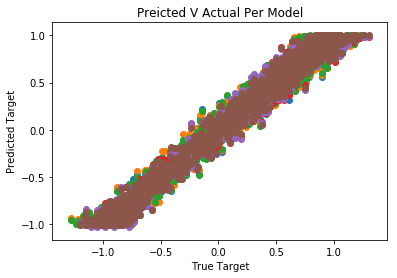

In [31]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

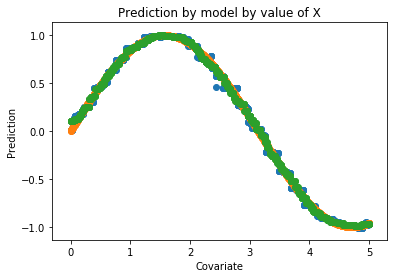

In [28]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

## Single dimension - multiple waves

** To extend our original model, let's add a high frequency cosine wave in our single dimension.  This will make the predicted function change faster and at varying rates across x **

Text(0.5,1,'X v y')

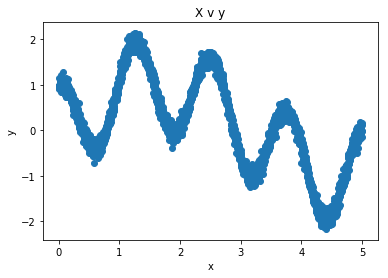

In [23]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

** Catboost and BartPy capture this faster moving sin wave pretty nicely, and come up with very similar predictions.  The linear model pretty much treats the cos wave as noise, and fits a curve close to the original one **

In [38]:
scores

[[0.9859508887939317, 0.9754440192208361, 0.48505787845960185],
 [0.9879610023229878, 0.9818666815894833, 0.509902473655678]]

Text(0,0.5,'Predicted Target')

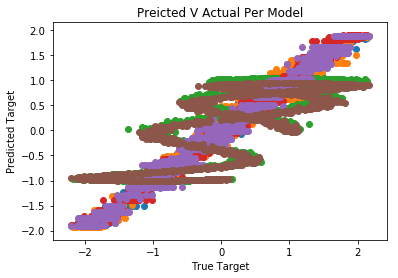

In [39]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

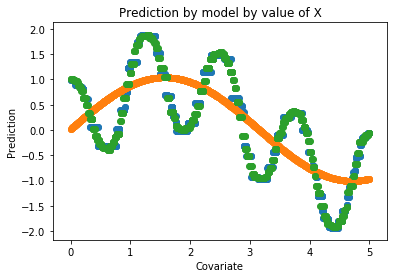

In [40]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

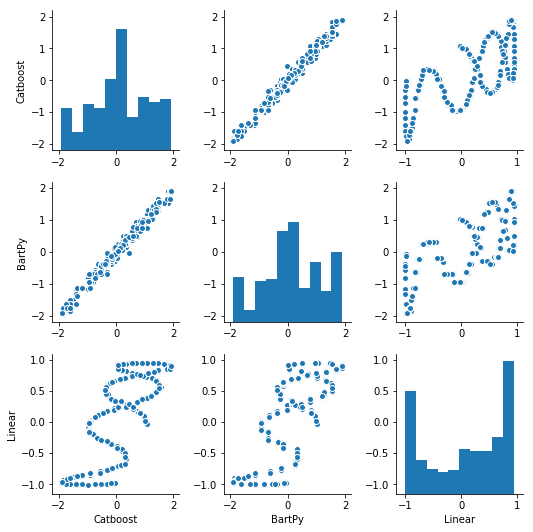

In [41]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Single dimension - discrete break points

** To make the model more complex, let's add some discrete dumps to make the curve less smooth.  This will test the ability of the models to handle very isolated effects in feature space **

Text(0.5,1,'X v y')

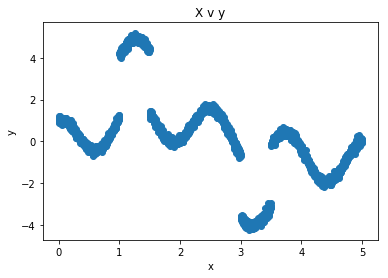

In [49]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
y[(X[:,0] < 1.5) & (X[:,0] > 1.)] += 3
y[(X[:,0] < 3.5) & (X[:,0] > 3.)] -= 3
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

In [52]:
scores

[[0.978236396149402, 0.9885191202572745, 0.2956934596944424],
 [0.9780588821482012, 0.9910936825961947, 0.3214370553664061]]

Text(0,0.5,'Predicted Target')

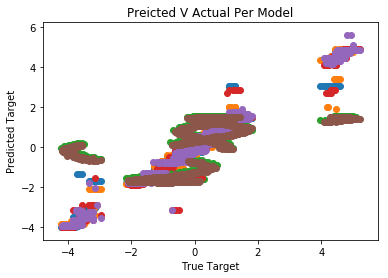

In [51]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

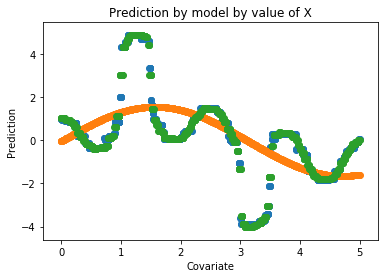

In [53]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

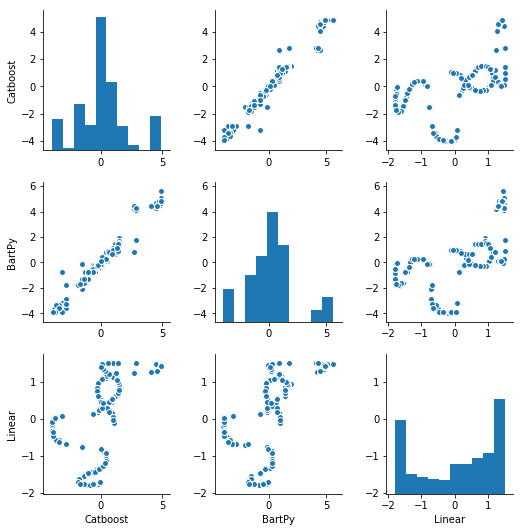

In [54]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

# Single meaningful dimension - additional noise dimensions

** It's important for the models to be able to correctly identify features that aren't important.  In this case, we just add normally distributed noise features.  This shouldn't be too difficult a problem to solve **

Text(0.5,1,'X v y')

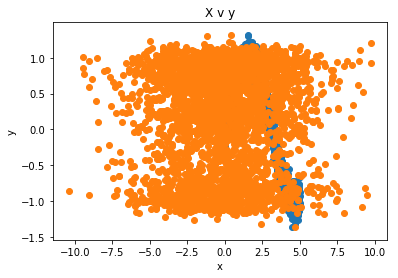

In [3]:
x = np.linspace(0, 5, 3000)
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

Starting burn


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:55<00:00,  2.85it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:13<00:00,  2.31it/s]


0:	learn: 0.7175707	test: 0.7040990	best: 0.7040990 (0)	total: 136ms	remaining: 2m 15s
1:	learn: 0.7010808	test: 0.6878546	best: 0.6878546 (1)	total: 186ms	remaining: 1m 32s
2:	learn: 0.6823818	test: 0.6695425	best: 0.6695425 (2)	total: 249ms	remaining: 1m 22s
3:	learn: 0.6657104	test: 0.6535362	best: 0.6535362 (3)	total: 293ms	remaining: 1m 12s
4:	learn: 0.6489471	test: 0.6373100	best: 0.6373100 (4)	total: 350ms	remaining: 1m 9s
5:	learn: 0.6324306	test: 0.6213249	best: 0.6213249 (5)	total: 414ms	remaining: 1m 8s
6:	learn: 0.6161934	test: 0.6055875	best: 0.6055875 (6)	total: 463ms	remaining: 1m 5s
7:	learn: 0.6019488	test: 0.5920636	best: 0.5920636 (7)	total: 526ms	remaining: 1m 5s
8:	learn: 0.5866242	test: 0.5770581	best: 0.5770581 (8)	total: 575ms	remaining: 1m 3s
9:	learn: 0.5718849	test: 0.5628124	best: 0.5628124 (9)	total: 618ms	remaining: 1m 1s
10:	learn: 0.5580358	test: 0.5495298	best: 0.5495298 (10)	total: 664ms	remaining: 59.7s
11:	learn: 0.5453708	test: 0.5373074	best: 0.537

94:	learn: 0.1232919	test: 0.1338667	best: 0.1338667 (94)	total: 4.47s	remaining: 42.6s
95:	learn: 0.1223576	test: 0.1330053	best: 0.1330053 (95)	total: 4.51s	remaining: 42.5s
96:	learn: 0.1215285	test: 0.1321830	best: 0.1321830 (96)	total: 4.55s	remaining: 42.4s
97:	learn: 0.1210848	test: 0.1318363	best: 0.1318363 (97)	total: 4.59s	remaining: 42.2s
98:	learn: 0.1199962	test: 0.1308709	best: 0.1308709 (98)	total: 4.62s	remaining: 42.1s
99:	learn: 0.1193607	test: 0.1303084	best: 0.1303084 (99)	total: 4.66s	remaining: 42s
100:	learn: 0.1183371	test: 0.1292438	best: 0.1292438 (100)	total: 4.69s	remaining: 41.8s
101:	learn: 0.1177255	test: 0.1286846	best: 0.1286846 (101)	total: 4.73s	remaining: 41.7s
102:	learn: 0.1170102	test: 0.1280365	best: 0.1280365 (102)	total: 4.77s	remaining: 41.6s
103:	learn: 0.1164556	test: 0.1275543	best: 0.1275543 (103)	total: 4.8s	remaining: 41.4s
104:	learn: 0.1160203	test: 0.1271187	best: 0.1271187 (104)	total: 4.87s	remaining: 41.5s
105:	learn: 0.1152537	tes

186:	learn: 0.0980567	test: 0.1087292	best: 0.1087292 (186)	total: 8.04s	remaining: 35s
187:	learn: 0.0979608	test: 0.1086242	best: 0.1086242 (187)	total: 8.08s	remaining: 34.9s
188:	learn: 0.0979165	test: 0.1085867	best: 0.1085867 (188)	total: 8.13s	remaining: 34.9s
189:	learn: 0.0978343	test: 0.1085185	best: 0.1085185 (189)	total: 8.17s	remaining: 34.8s
190:	learn: 0.0977760	test: 0.1084437	best: 0.1084437 (190)	total: 8.2s	remaining: 34.7s
191:	learn: 0.0977351	test: 0.1083777	best: 0.1083777 (191)	total: 8.24s	remaining: 34.7s
192:	learn: 0.0977287	test: 0.1083757	best: 0.1083757 (192)	total: 8.26s	remaining: 34.5s
193:	learn: 0.0976507	test: 0.1083359	best: 0.1083359 (193)	total: 8.3s	remaining: 34.5s
194:	learn: 0.0976120	test: 0.1082690	best: 0.1082690 (194)	total: 8.34s	remaining: 34.4s
195:	learn: 0.0975977	test: 0.1082425	best: 0.1082425 (195)	total: 8.38s	remaining: 34.4s
196:	learn: 0.0975763	test: 0.1082229	best: 0.1082229 (196)	total: 8.41s	remaining: 34.3s
197:	learn: 0.

278:	learn: 0.0950606	test: 0.1057171	best: 0.1057171 (278)	total: 11.7s	remaining: 30.3s
279:	learn: 0.0950578	test: 0.1057045	best: 0.1057045 (279)	total: 11.8s	remaining: 30.3s
280:	learn: 0.0950555	test: 0.1056971	best: 0.1056971 (280)	total: 11.8s	remaining: 30.2s
281:	learn: 0.0950489	test: 0.1056768	best: 0.1056768 (281)	total: 11.8s	remaining: 30.2s
282:	learn: 0.0950376	test: 0.1056589	best: 0.1056589 (282)	total: 11.9s	remaining: 30.1s
283:	learn: 0.0950312	test: 0.1056531	best: 0.1056531 (283)	total: 11.9s	remaining: 30.1s
284:	learn: 0.0950109	test: 0.1056176	best: 0.1056176 (284)	total: 12s	remaining: 30s
285:	learn: 0.0950099	test: 0.1056128	best: 0.1056128 (285)	total: 12s	remaining: 29.9s
286:	learn: 0.0950099	test: 0.1056127	best: 0.1056127 (286)	total: 12s	remaining: 29.8s
287:	learn: 0.0949703	test: 0.1055690	best: 0.1055690 (287)	total: 12s	remaining: 29.8s
288:	learn: 0.0949390	test: 0.1055558	best: 0.1055558 (288)	total: 12.1s	remaining: 29.8s
289:	learn: 0.094899

370:	learn: 0.0936397	test: 0.1044897	best: 0.1044897 (370)	total: 14.8s	remaining: 25.1s
371:	learn: 0.0936306	test: 0.1044871	best: 0.1044871 (371)	total: 14.9s	remaining: 25.1s
372:	learn: 0.0936253	test: 0.1044882	best: 0.1044871 (371)	total: 15s	remaining: 25.1s
373:	learn: 0.0936252	test: 0.1044862	best: 0.1044862 (373)	total: 15s	remaining: 25.1s
374:	learn: 0.0936247	test: 0.1044801	best: 0.1044801 (374)	total: 15s	remaining: 25s
375:	learn: 0.0935830	test: 0.1044613	best: 0.1044613 (375)	total: 15s	remaining: 25s
376:	learn: 0.0934694	test: 0.1044051	best: 0.1044051 (376)	total: 15.1s	remaining: 24.9s
377:	learn: 0.0934633	test: 0.1043984	best: 0.1043984 (377)	total: 15.2s	remaining: 24.9s
378:	learn: 0.0934632	test: 0.1043979	best: 0.1043979 (378)	total: 15.2s	remaining: 24.9s
379:	learn: 0.0934603	test: 0.1043907	best: 0.1043907 (379)	total: 15.2s	remaining: 24.8s
380:	learn: 0.0934354	test: 0.1043778	best: 0.1043778 (380)	total: 15.3s	remaining: 24.8s
381:	learn: 0.0934354	

462:	learn: 0.0918929	test: 0.1036446	best: 0.1036152 (457)	total: 18.2s	remaining: 21.1s
463:	learn: 0.0918380	test: 0.1036110	best: 0.1036110 (463)	total: 18.2s	remaining: 21s
464:	learn: 0.0917928	test: 0.1035923	best: 0.1035923 (464)	total: 18.3s	remaining: 21s
465:	learn: 0.0917928	test: 0.1035917	best: 0.1035917 (465)	total: 18.3s	remaining: 20.9s
466:	learn: 0.0917925	test: 0.1035887	best: 0.1035887 (466)	total: 18.3s	remaining: 20.9s
467:	learn: 0.0917774	test: 0.1035609	best: 0.1035609 (467)	total: 18.3s	remaining: 20.9s
468:	learn: 0.0917244	test: 0.1035206	best: 0.1035206 (468)	total: 18.4s	remaining: 20.8s
469:	learn: 0.0917244	test: 0.1035201	best: 0.1035201 (469)	total: 18.4s	remaining: 20.7s
470:	learn: 0.0917234	test: 0.1035191	best: 0.1035191 (470)	total: 18.4s	remaining: 20.7s
471:	learn: 0.0917101	test: 0.1035218	best: 0.1035191 (470)	total: 18.5s	remaining: 20.7s
472:	learn: 0.0916450	test: 0.1035011	best: 0.1035011 (472)	total: 18.5s	remaining: 20.6s
473:	learn: 0.

554:	learn: 0.0894990	test: 0.1029930	best: 0.1029930 (554)	total: 22.1s	remaining: 17.7s
555:	learn: 0.0894946	test: 0.1029848	best: 0.1029848 (555)	total: 22.1s	remaining: 17.6s
556:	learn: 0.0894380	test: 0.1029516	best: 0.1029516 (556)	total: 22.1s	remaining: 17.6s
557:	learn: 0.0894349	test: 0.1029444	best: 0.1029444 (557)	total: 22.2s	remaining: 17.6s
558:	learn: 0.0894258	test: 0.1029221	best: 0.1029221 (558)	total: 22.2s	remaining: 17.5s
559:	learn: 0.0894226	test: 0.1029140	best: 0.1029140 (559)	total: 22.2s	remaining: 17.5s
560:	learn: 0.0893685	test: 0.1029158	best: 0.1029140 (559)	total: 22.3s	remaining: 17.4s
561:	learn: 0.0893684	test: 0.1029170	best: 0.1029140 (559)	total: 22.3s	remaining: 17.4s
562:	learn: 0.0893649	test: 0.1029109	best: 0.1029109 (562)	total: 22.4s	remaining: 17.4s
563:	learn: 0.0893577	test: 0.1029019	best: 0.1029019 (563)	total: 22.4s	remaining: 17.3s
564:	learn: 0.0893452	test: 0.1029070	best: 0.1029019 (563)	total: 22.5s	remaining: 17.3s
565:	learn

646:	learn: 0.0870664	test: 0.1026743	best: 0.1026007 (624)	total: 27.3s	remaining: 14.9s
647:	learn: 0.0870482	test: 0.1026734	best: 0.1026007 (624)	total: 27.4s	remaining: 14.9s
648:	learn: 0.0869590	test: 0.1026916	best: 0.1026007 (624)	total: 27.4s	remaining: 14.8s
649:	learn: 0.0869480	test: 0.1026917	best: 0.1026007 (624)	total: 27.5s	remaining: 14.8s
650:	learn: 0.0868885	test: 0.1026837	best: 0.1026007 (624)	total: 27.5s	remaining: 14.8s
651:	learn: 0.0868684	test: 0.1026492	best: 0.1026007 (624)	total: 27.6s	remaining: 14.7s
652:	learn: 0.0868612	test: 0.1026463	best: 0.1026007 (624)	total: 27.6s	remaining: 14.7s
653:	learn: 0.0868371	test: 0.1026733	best: 0.1026007 (624)	total: 27.7s	remaining: 14.6s
654:	learn: 0.0868036	test: 0.1026467	best: 0.1026007 (624)	total: 27.7s	remaining: 14.6s
655:	learn: 0.0868002	test: 0.1026481	best: 0.1026007 (624)	total: 27.8s	remaining: 14.6s
656:	learn: 0.0867848	test: 0.1026324	best: 0.1026007 (624)	total: 27.8s	remaining: 14.5s
657:	learn

738:	learn: 0.0851144	test: 0.1025087	best: 0.1024436 (694)	total: 32.4s	remaining: 11.4s
739:	learn: 0.0850687	test: 0.1025345	best: 0.1024436 (694)	total: 32.4s	remaining: 11.4s
740:	learn: 0.0850534	test: 0.1025314	best: 0.1024436 (694)	total: 32.5s	remaining: 11.3s
741:	learn: 0.0850439	test: 0.1025277	best: 0.1024436 (694)	total: 32.6s	remaining: 11.3s
742:	learn: 0.0850435	test: 0.1025254	best: 0.1024436 (694)	total: 32.6s	remaining: 11.3s
743:	learn: 0.0850364	test: 0.1025200	best: 0.1024436 (694)	total: 32.8s	remaining: 11.3s
744:	learn: 0.0850225	test: 0.1025025	best: 0.1024436 (694)	total: 32.9s	remaining: 11.2s
745:	learn: 0.0850045	test: 0.1025127	best: 0.1024436 (694)	total: 32.9s	remaining: 11.2s
746:	learn: 0.0849983	test: 0.1025186	best: 0.1024436 (694)	total: 33s	remaining: 11.2s
747:	learn: 0.0849808	test: 0.1025237	best: 0.1024436 (694)	total: 33.1s	remaining: 11.1s
748:	learn: 0.0849782	test: 0.1025191	best: 0.1024436 (694)	total: 33.2s	remaining: 11.1s
749:	learn: 

830:	learn: 0.0838287	test: 0.1025283	best: 0.1024436 (694)	total: 38.1s	remaining: 7.76s
831:	learn: 0.0838106	test: 0.1025338	best: 0.1024436 (694)	total: 38.2s	remaining: 7.71s
832:	learn: 0.0838099	test: 0.1025347	best: 0.1024436 (694)	total: 38.2s	remaining: 7.67s
833:	learn: 0.0837784	test: 0.1025569	best: 0.1024436 (694)	total: 38.3s	remaining: 7.62s
834:	learn: 0.0837773	test: 0.1025568	best: 0.1024436 (694)	total: 38.3s	remaining: 7.58s
835:	learn: 0.0837707	test: 0.1025596	best: 0.1024436 (694)	total: 38.4s	remaining: 7.53s
836:	learn: 0.0837670	test: 0.1025566	best: 0.1024436 (694)	total: 38.5s	remaining: 7.49s
837:	learn: 0.0837503	test: 0.1025650	best: 0.1024436 (694)	total: 38.5s	remaining: 7.45s
838:	learn: 0.0837496	test: 0.1025640	best: 0.1024436 (694)	total: 38.6s	remaining: 7.4s
839:	learn: 0.0837489	test: 0.1025646	best: 0.1024436 (694)	total: 38.6s	remaining: 7.35s
840:	learn: 0.0837469	test: 0.1025604	best: 0.1024436 (694)	total: 38.6s	remaining: 7.3s
841:	learn: 

922:	learn: 0.0827485	test: 0.1026655	best: 0.1024436 (694)	total: 42.8s	remaining: 3.57s
923:	learn: 0.0827357	test: 0.1026520	best: 0.1024436 (694)	total: 42.9s	remaining: 3.53s
924:	learn: 0.0827231	test: 0.1026597	best: 0.1024436 (694)	total: 42.9s	remaining: 3.48s
925:	learn: 0.0827082	test: 0.1026409	best: 0.1024436 (694)	total: 43s	remaining: 3.44s
926:	learn: 0.0826940	test: 0.1026569	best: 0.1024436 (694)	total: 43.1s	remaining: 3.39s
927:	learn: 0.0826900	test: 0.1026577	best: 0.1024436 (694)	total: 43.1s	remaining: 3.34s
928:	learn: 0.0826900	test: 0.1026582	best: 0.1024436 (694)	total: 43.1s	remaining: 3.3s
929:	learn: 0.0826892	test: 0.1026607	best: 0.1024436 (694)	total: 43.2s	remaining: 3.25s
930:	learn: 0.0826891	test: 0.1026623	best: 0.1024436 (694)	total: 43.2s	remaining: 3.2s
931:	learn: 0.0826890	test: 0.1026608	best: 0.1024436 (694)	total: 43.2s	remaining: 3.15s
932:	learn: 0.0826660	test: 0.1026547	best: 0.1024436 (694)	total: 43.3s	remaining: 3.11s
933:	learn: 0.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:40<00:00,  3.12it/s]


Starting sampling


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 692/1000 [05:07<02:17,  2.25it/s]

In [ ]:
scores

Text(0,0.5,'Predicted Target')

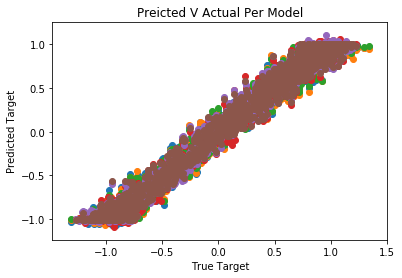

In [8]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

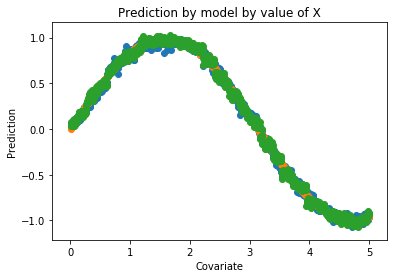

In [9]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

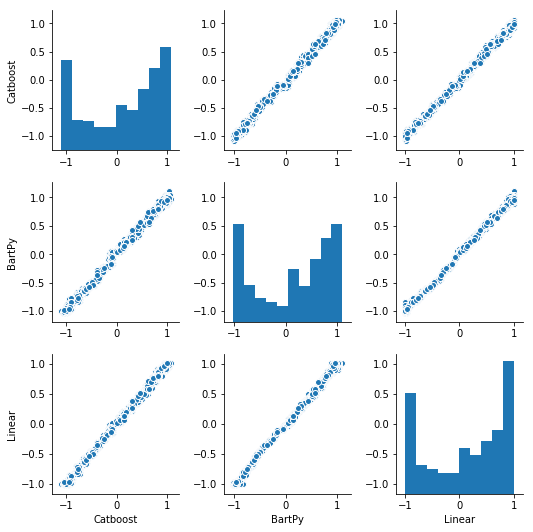

In [10]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Mixture of multiple meaningful dimensions and noise dimensions

** Both catboost and BartPy have performed well with noise dimensions and rapidly moving targets, let's combine them to make a relatively difficult test for tree models **

Text(0.5,1,'X v y')

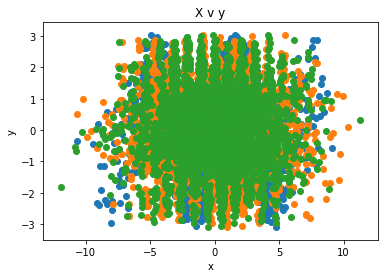

In [3]:
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.sin(5 * X[:, 1]) + np.cos(-6 * X[:, 3])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 3], y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")


In [4]:
scores, predictions, trained_models = compare_models(X, y, [fit_bartpy])

Starting burn


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:51<00:00,  2.91it/s]


Starting sampling


  0%|                                                                                                                                                                                                                                                                         | 0/1000 [00:00<?, ?it/s]


AttributeError: 'DecisionNode' object has no attribute '_conditions'

In [5]:
scores

[[0.604718647284356], [0.6260166940121801]]

In [13]:
scores

[[0.5464956574257351, 0.5697758802204275, 0.32396717209436254],
 [0.532104135246146, 0.656279388545232, 0.3370101754372119]]

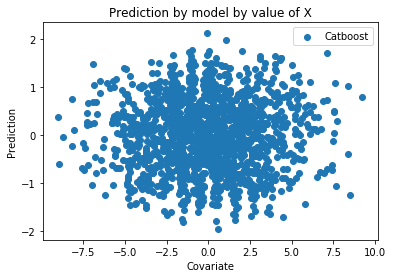

In [6]:
#plt.scatter(X[:1500,3],predictions[0][1], label = "Bart")
#plt.scatter(X[:1500,3],predictions[0][2], label = "Ols")
plt.scatter(X[:1500,3],predictions[0][0], label = "Catboost")
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")
plt.legend(loc = "best")

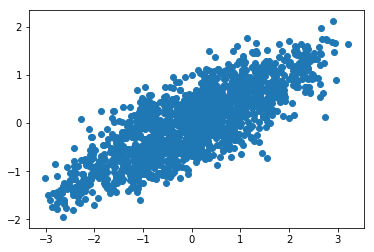

In [7]:
plt.scatter(y[:1500],predictions[0][0], label = "Catboost")
#plt.scatter(y[:1500],predictions[0][1], label = "Catboost")
#plt.scatter(y[:1500],predictions[0][2], label = "Catboost")

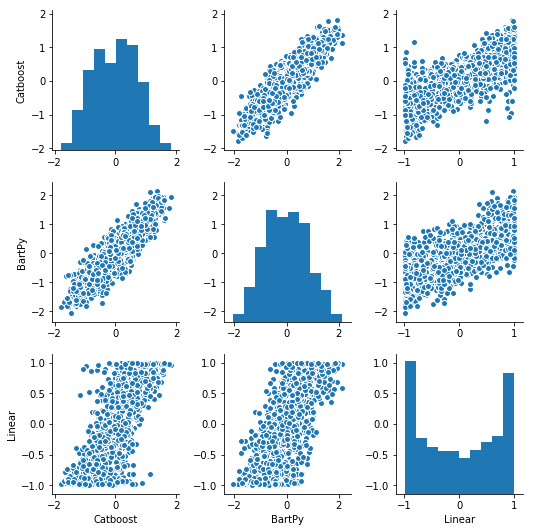

In [16]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)